<img src="https://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Reinforcement Learning for Finance

**Chapter 04 &mdash; Simulated Data**

&copy; Dr. Yves J. Hilpisch

<a href="https://tpq.io" target="_blank">https://tpq.io</a> | <a href="https://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@tpq.io">team@tpq.io</a>

## Finance Environment

In [1]:
class ActionSpace:
    def sample(self):
        return random.randint(0, 1)

In [2]:
import numpy as np
import pandas as pd
from numpy.random import default_rng

In [3]:
rng = default_rng(seed=100)

In [4]:
class NoisyData:
    url = 'https://certificate.tpq.io/findata.csv'
    def __init__(self, symbol, feature, n_features=4,
                 min_accuracy=0.485, noise=True,
                 noise_std=0.001):
        self.symbol = symbol
        self.feature = feature
        self.n_features = n_features
        self.noise = noise
        self.noise_std = noise_std
        self.action_space = ActionSpace()
        self.min_accuracy = min_accuracy
        self._get_data()
        self._prepare_data()
    def _get_data(self):
        self.raw = pd.read_csv(self.url,
                index_col=0, parse_dates=True)

In [5]:
class NoisyData(NoisyData):
    def _prepare_data(self):
        self.data = pd.DataFrame(self.raw[self.symbol]).dropna()
        if self.noise:
            std = self.data.mean() * self.noise_std
            self.data[self.symbol] = (self.data[self.symbol] +
                rng.normal(0, std, len(self.data)))
        self.data['r'] = np.log(self.data / self.data.shift(1))
        self.data['d'] = np.where(self.data['r'] > 0, 1, 0)
        self.data.dropna(inplace=True)
        ma, mi = self.data.max(), self.data.min()
        self.data_ = (self.data - mi) / (ma - mi)
    def reset(self):
        if self.noise:
            self._prepare_data()
        self.bar = self.n_features
        self.treward = 0
        state = self.data_[self.feature].iloc[
            self.bar - self.n_features:self.bar].values
        return state, {}

In [6]:
class NoisyData(NoisyData):
    def step(self, action):
        if action == self.data['d'].iloc[self.bar]:
            correct = True
        else:
            correct = False
        reward = 1 if correct else 0 
        self.treward += reward
        self.bar += 1
        self.accuracy = self.treward / (self.bar - self.n_features)
        if self.bar >= len(self.data):
            done = True
        elif reward == 1:
            done = False
        elif (self.accuracy < self.min_accuracy and
              self.bar > self.n_features + 15):
            done = True
        else:
            done = False
        next_state = self.data_[self.feature].iloc[
            self.bar - self.n_features:self.bar].values
        return next_state, reward, done, False, {}

In [7]:
fin = NoisyData(symbol='EUR=', feature='EUR=',
                noise=True, noise_std=0.005)

In [8]:
fin.reset()

(array([0.79295659, 0.81097879, 0.78840972, 0.80597193]), {})

In [9]:
fin.reset()

(array([0.80642276, 0.77840938, 0.80096369, 0.76938581]), {})

In [10]:
fin = NoisyData('EUR=', 'r', n_features=4,
                noise=True, noise_std=0.005)

In [11]:
fin.reset()

(array([0.54198375, 0.30674865, 0.45688528, 0.52884033]), {})

In [12]:
fin.reset()

(array([0.37967631, 0.40190291, 0.49196183, 0.47536065]), {})

In [13]:
from pylab import plt, mpl
plt.style.use('seaborn-v0_8')
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

In [14]:
import warnings
warnings.simplefilter('ignore')

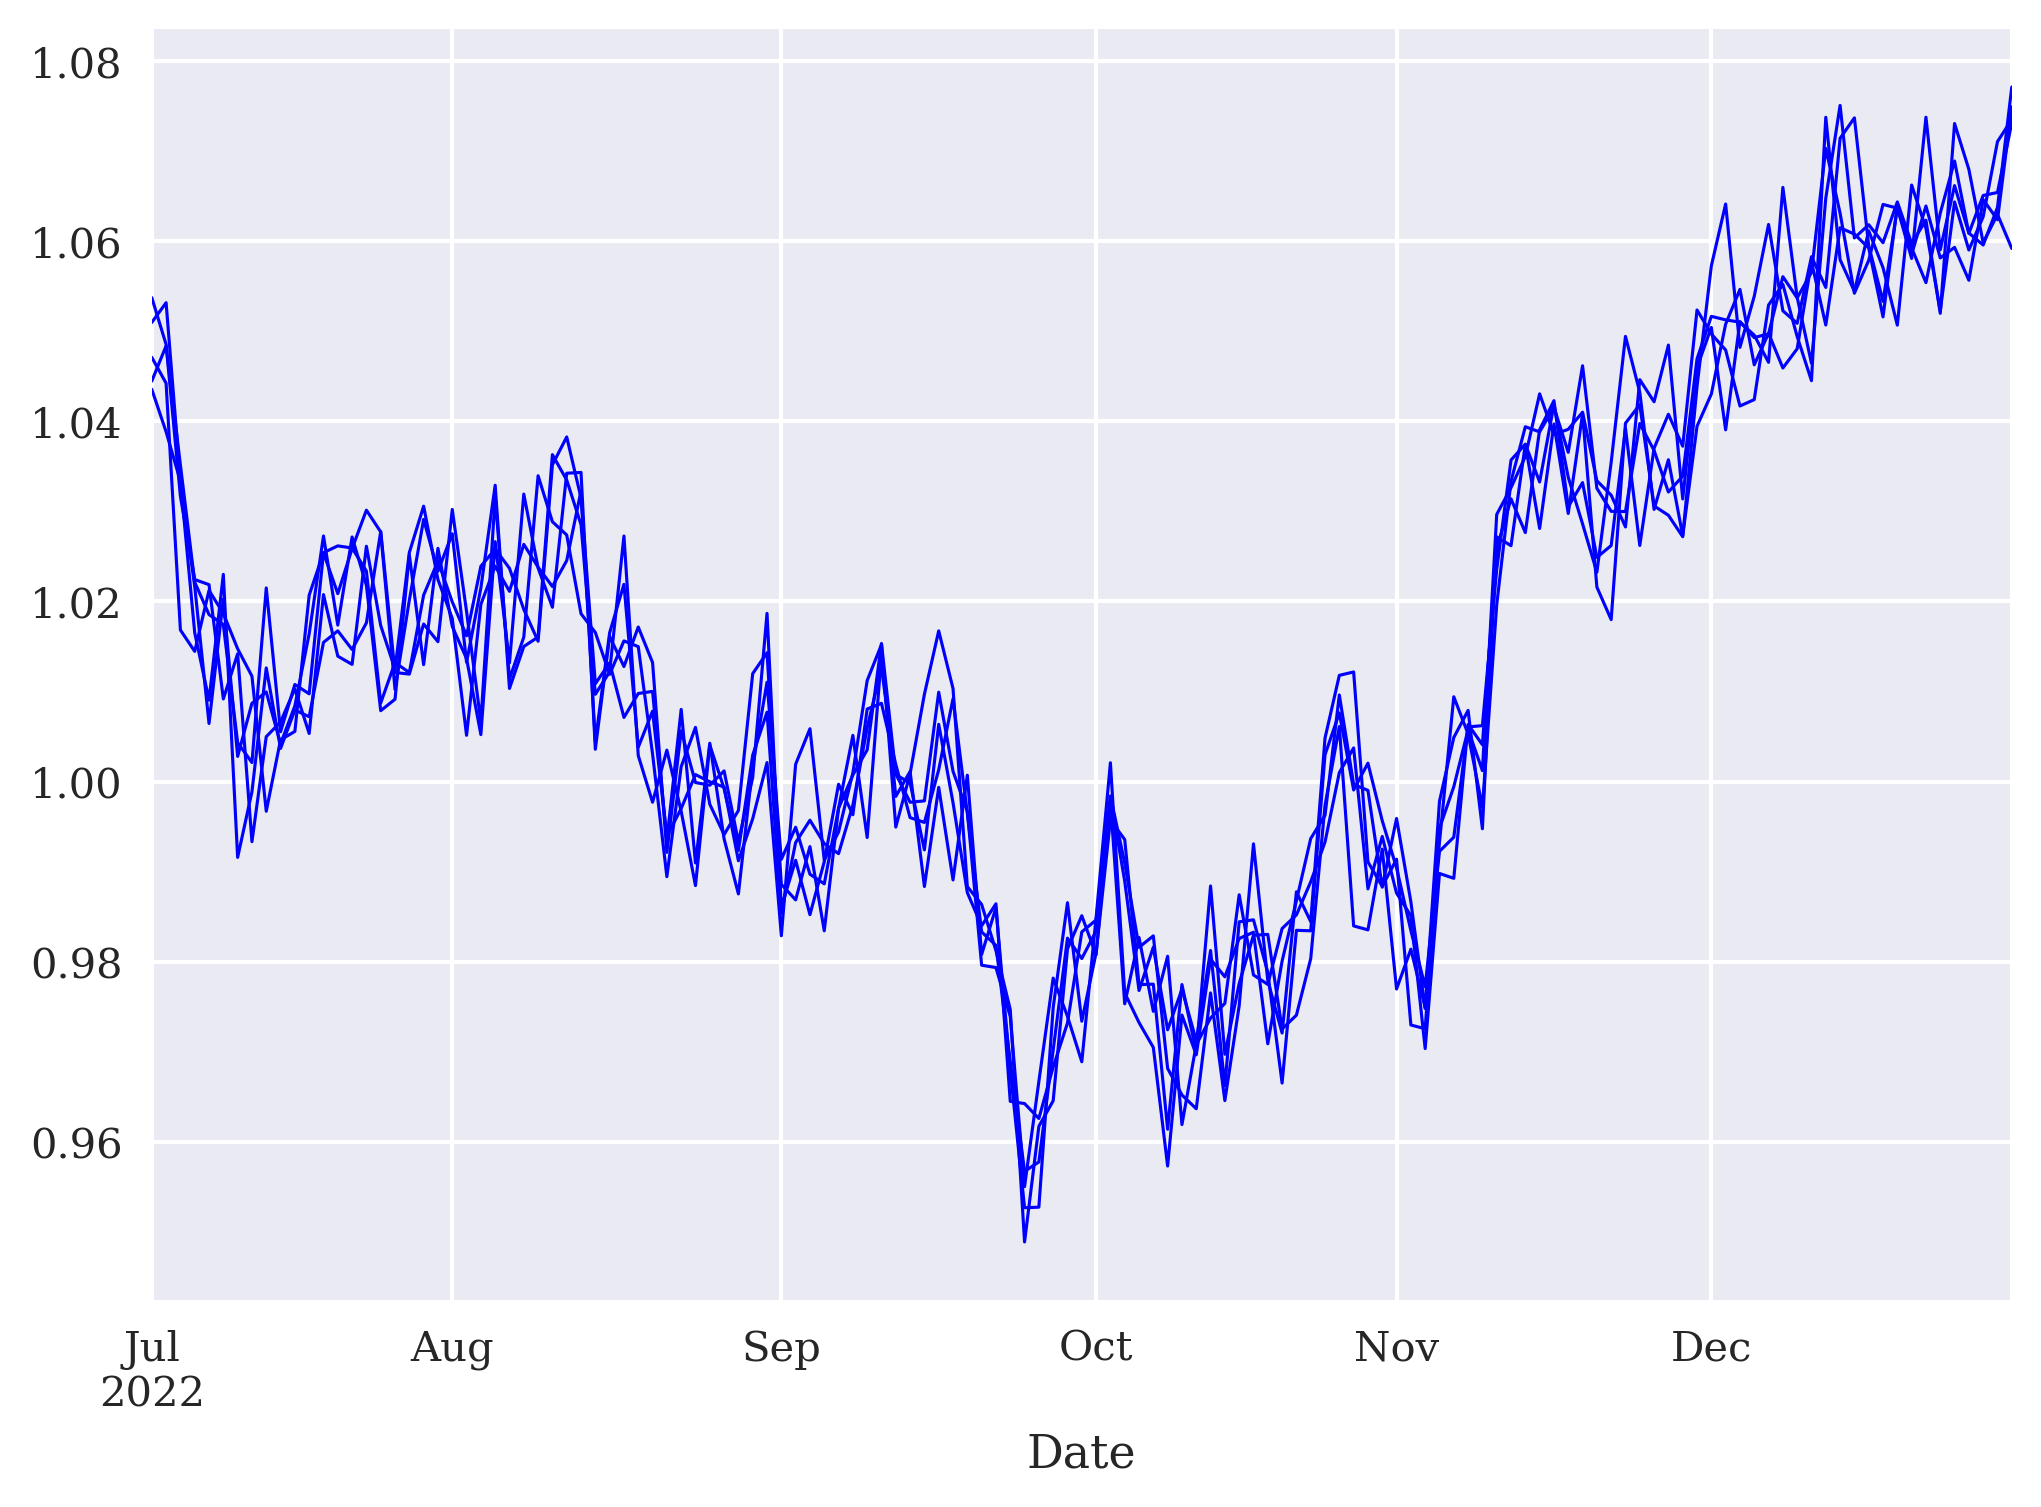

In [15]:
for _ in range(5):
    fin.reset()
    fin.data[fin.symbol].loc['2022-7-1':].plot(lw=0.75, c='b')

In [16]:
%run dqlagent.py

In [17]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [18]:
agent = DQLAgent(fin.symbol, fin.feature, fin.n_features, fin)

In [19]:
%time agent.learn(250)

episode= 250 | treward=1361.000 | max=1468.000
CPU times: total: 2min 19s
Wall time: 1min 57s


In [20]:
agent.test(5)

total reward=2604 | accuracy=0.601
total reward=2604 | accuracy=0.608
total reward=2604 | accuracy=0.611
total reward=2604 | accuracy=0.605
total reward=2604 | accuracy=0.616



In [21]:
class Simulation:
    def __init__(self, symbol, feature, n_features,
                 start, end, periods,
                 min_accuracy=0.525, x0=100,
                 kappa=1, theta=100, sigma=0.2,
                 normalize=True, new=False):
        self.symbol = symbol
        self.feature = feature
        self.n_features = n_features
        self.start = start
        self.end = end
        self.periods = periods
        self.x0 = x0
        self.kappa = kappa
        self.theta = theta
        self.sigma = sigma
        self.min_accuracy = min_accuracy
        self.normalize = normalize
        self.new = new
        self.action_space = ActionSpace()
        self._simulate_data()
        self._prepare_data()

In [22]:
import math
class Simulation(Simulation):
    def _simulate_data(self):
        index = pd.date_range(start=self.start,
                    end=self.end, periods=self.periods)
        x = [self.x0]
        dt = (index[-1] - index[0]).days / 365 / self.periods
        for t in range(1, len(index)):
            x_ = (x[t - 1] + self.kappa * (self.theta - x[t - 1]) * dt +
                  x[t - 1] * self.sigma * math.sqrt(dt) *
                  random.gauss(0, 1))
            x.append(x_)
        
        self.data = pd.DataFrame(x, columns=[self.symbol], index=index)

In [23]:
class Simulation(Simulation):
    def _prepare_data(self):
        self.data['r'] = np.log(self.data / self.data.shift(1))
        self.data.dropna(inplace=True)
        if self.normalize:
            self.mu = self.data.mean()
            self.std = self.data.std()
            self.data_ = (self.data - self.mu) / self.std
        else:
            self.data_ = self.data.copy()
        self.data['d'] = np.where(self.data['r'] > 0, 1, 0)
        self.data['d'] = self.data['d'].astype(int)

In [24]:
class Simulation(Simulation):
    def _get_state(self):
        return self.data_[self.feature].iloc[self.bar -
                                self.n_features:self.bar]
    def seed(self, seed):
        random.seed(seed)
        tf.random.set_seed(seed)
    def reset(self):
        self.treward = 0
        self.accuracy = 0
        self.bar = self.n_features
        if self.new:
            self._simulate_data()
            self._prepare_data()
        state = self._get_state()
        return state.values, {}

In [25]:
class Simulation(Simulation):
    def step(self, action):
        if action == self.data['d'].iloc[self.bar]:
            correct = True
        else:
            correct = False
        reward = 1 if correct else 0 
        self.treward += reward
        self.bar += 1
        self.accuracy = self.treward / (self.bar - self.n_features)
        if self.bar >= len(self.data):
            done = True
        elif reward == 1:
            done = False
        elif (self.accuracy < self.min_accuracy and self.bar > 25):
            done = True
        else:
            done = False
        next_state = self.data_[self.feature].iloc[
            self.bar - self.n_features:self.bar].values
        return next_state, reward, done, False, {}

In [26]:
sym = 'EUR='

In [27]:
env_base = Simulation(sym, sym, 5, start='2024-1-1', end='2025-1-1',
                 periods=252, x0=1, kappa=1, theta=1.1, sigma=0.0,
                 normalize=True)
env_base.seed(100)

In [28]:
env_trend = Simulation(sym, sym, 5, start='2024-1-1', end='2025-1-1',
                 periods=252, x0=1, kappa=1, theta=2, sigma=0.1,
                 normalize=True)
env_trend.seed(100)

In [29]:
env_mrev = Simulation(sym, sym, 5, start='2024-1-1', end='2025-1-1',
                 periods=252, x0=1, kappa=1, theta=1, sigma=0.1,
                 normalize=True)
env_mrev.seed(100)

In [30]:
env_mrev.data[sym].iloc[:3]

2024-01-02 10:59:45.657370517    1.004236
2024-01-03 21:59:31.314741035    1.009752
2024-01-05 08:59:16.972111553    1.011010
Name: EUR=, dtype: float64

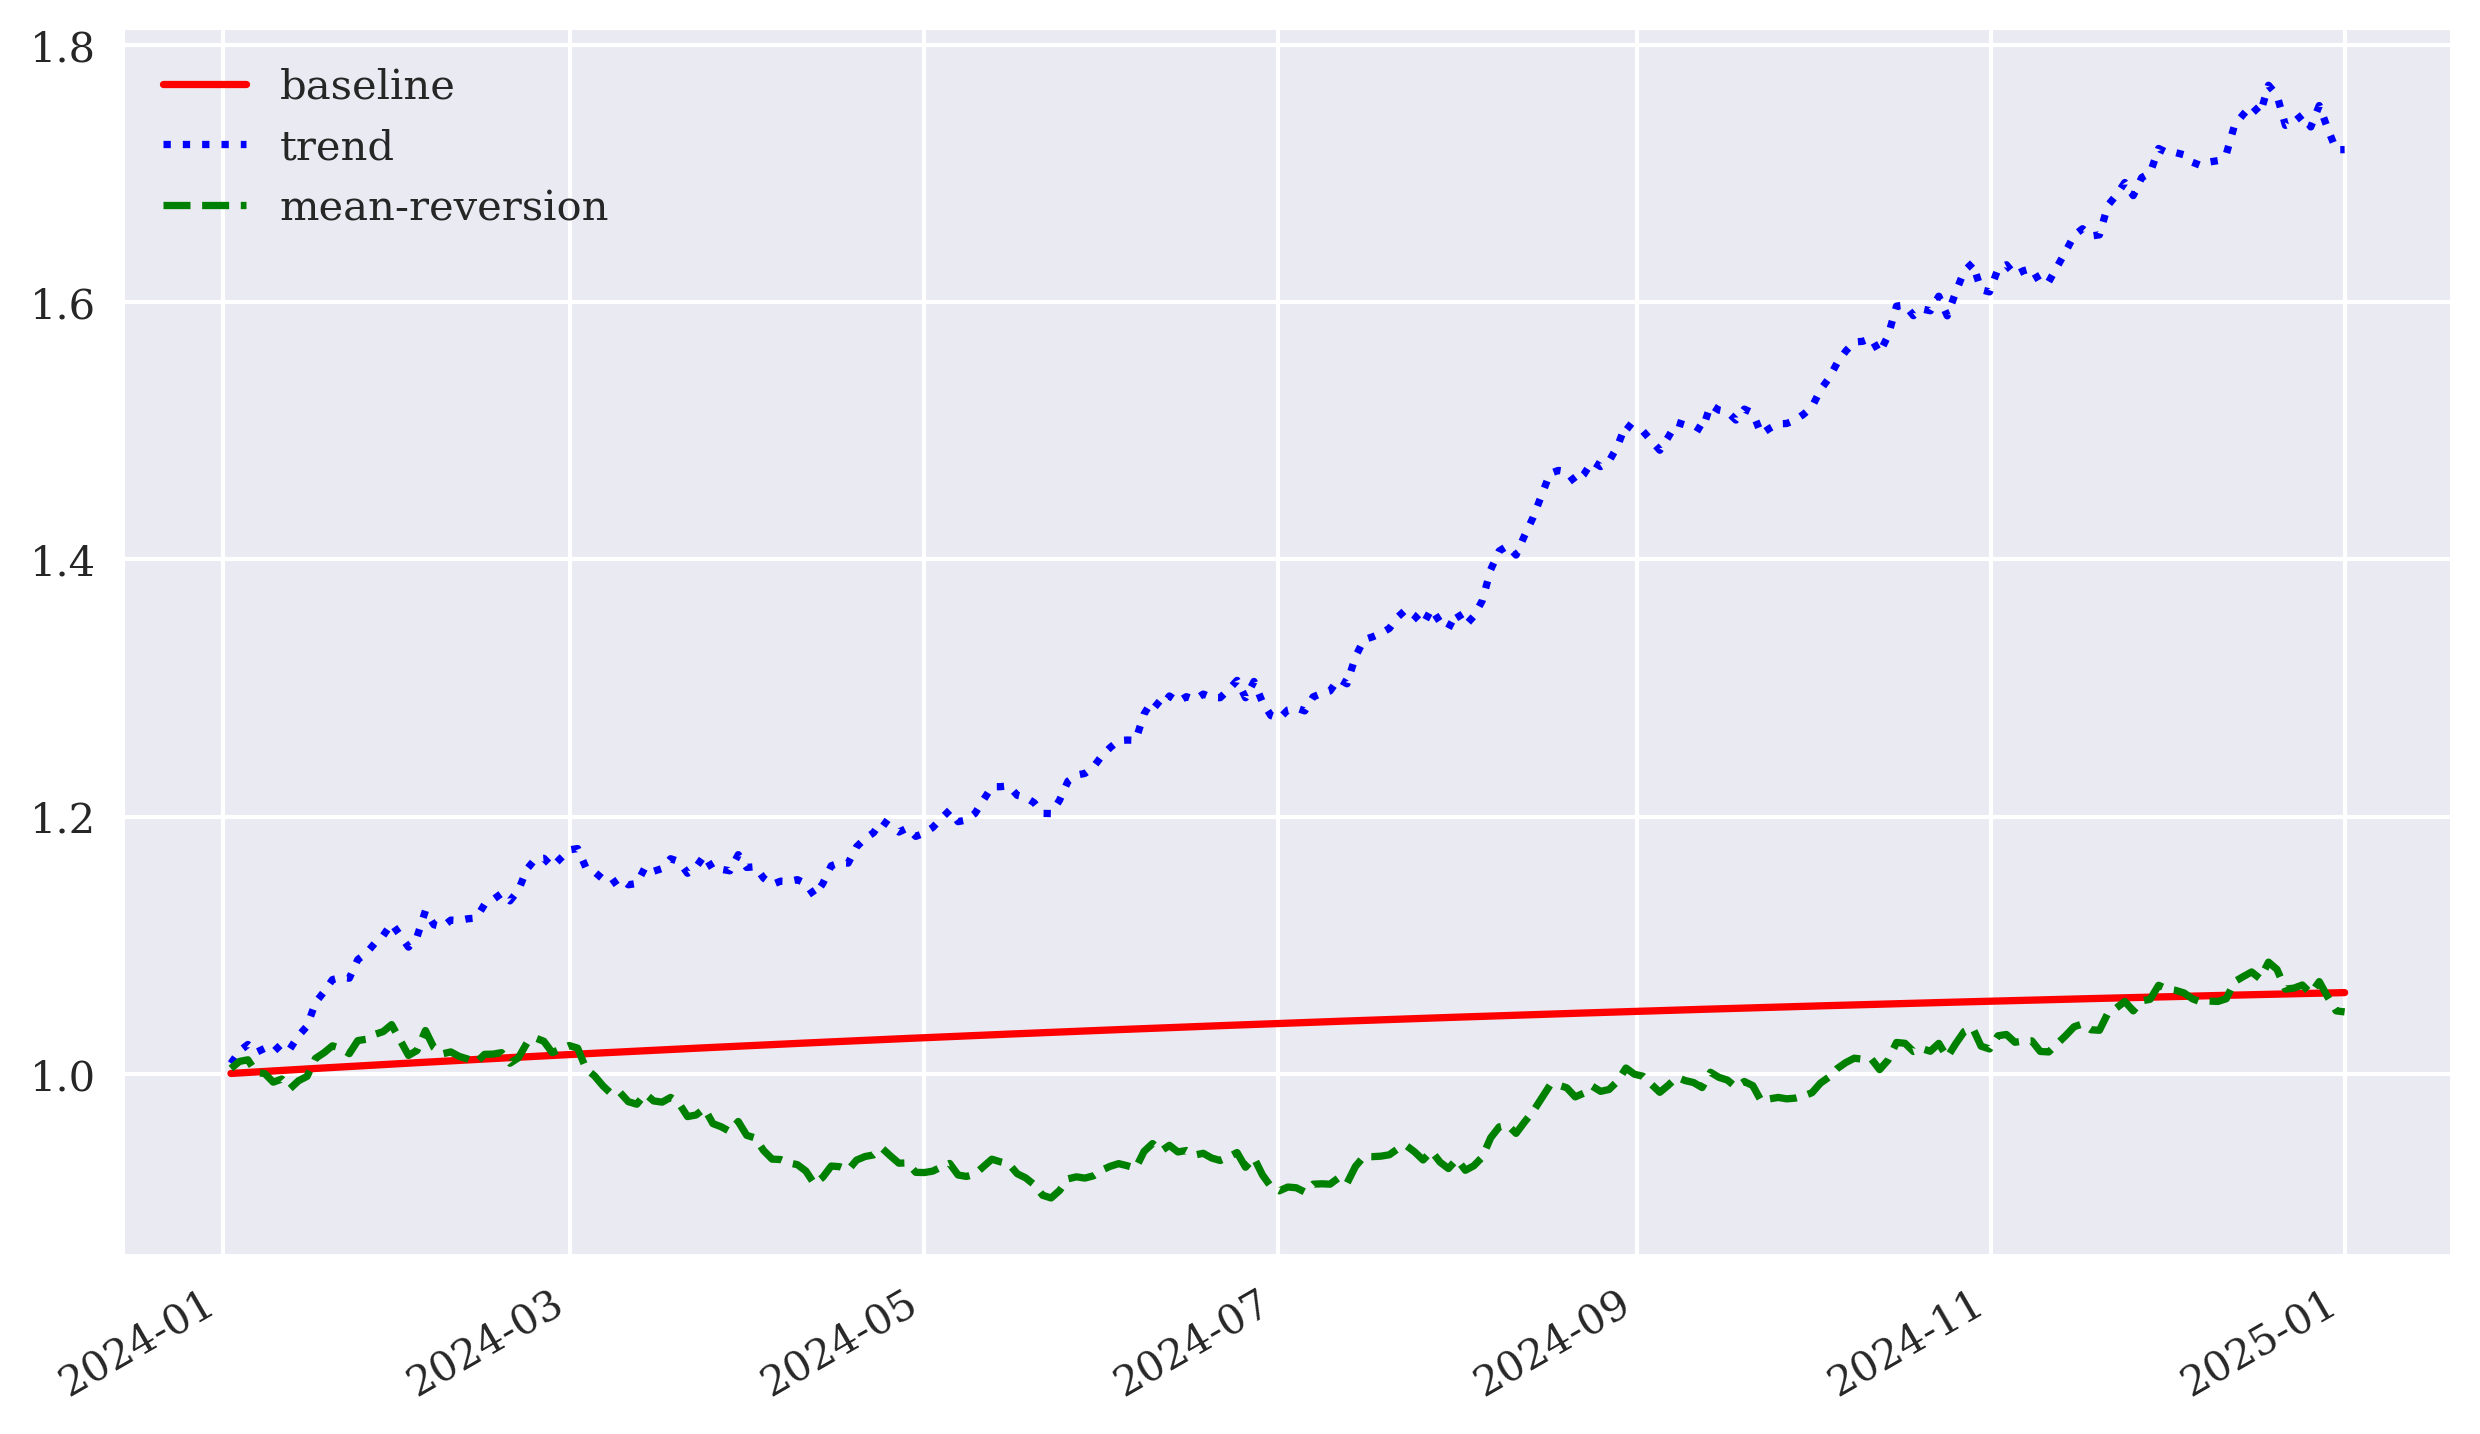

In [31]:
env_base.data[sym].plot(figsize=(10, 6), label='baseline', style='r')
env_trend.data[sym].plot(label='trend', style='b:')
env_mrev.data[sym].plot(label='mean-reversion', style='g--')
plt.legend();

In [32]:
sim = Simulation(sym, 'r', 4, start='2024-1-1', end='2028-1-1',
                 periods=2 * 252, min_accuracy=0.485, x0=1,
                 kappa=2, theta=2, sigma=0.15,
                 normalize=True, new=True)
sim.seed(100)

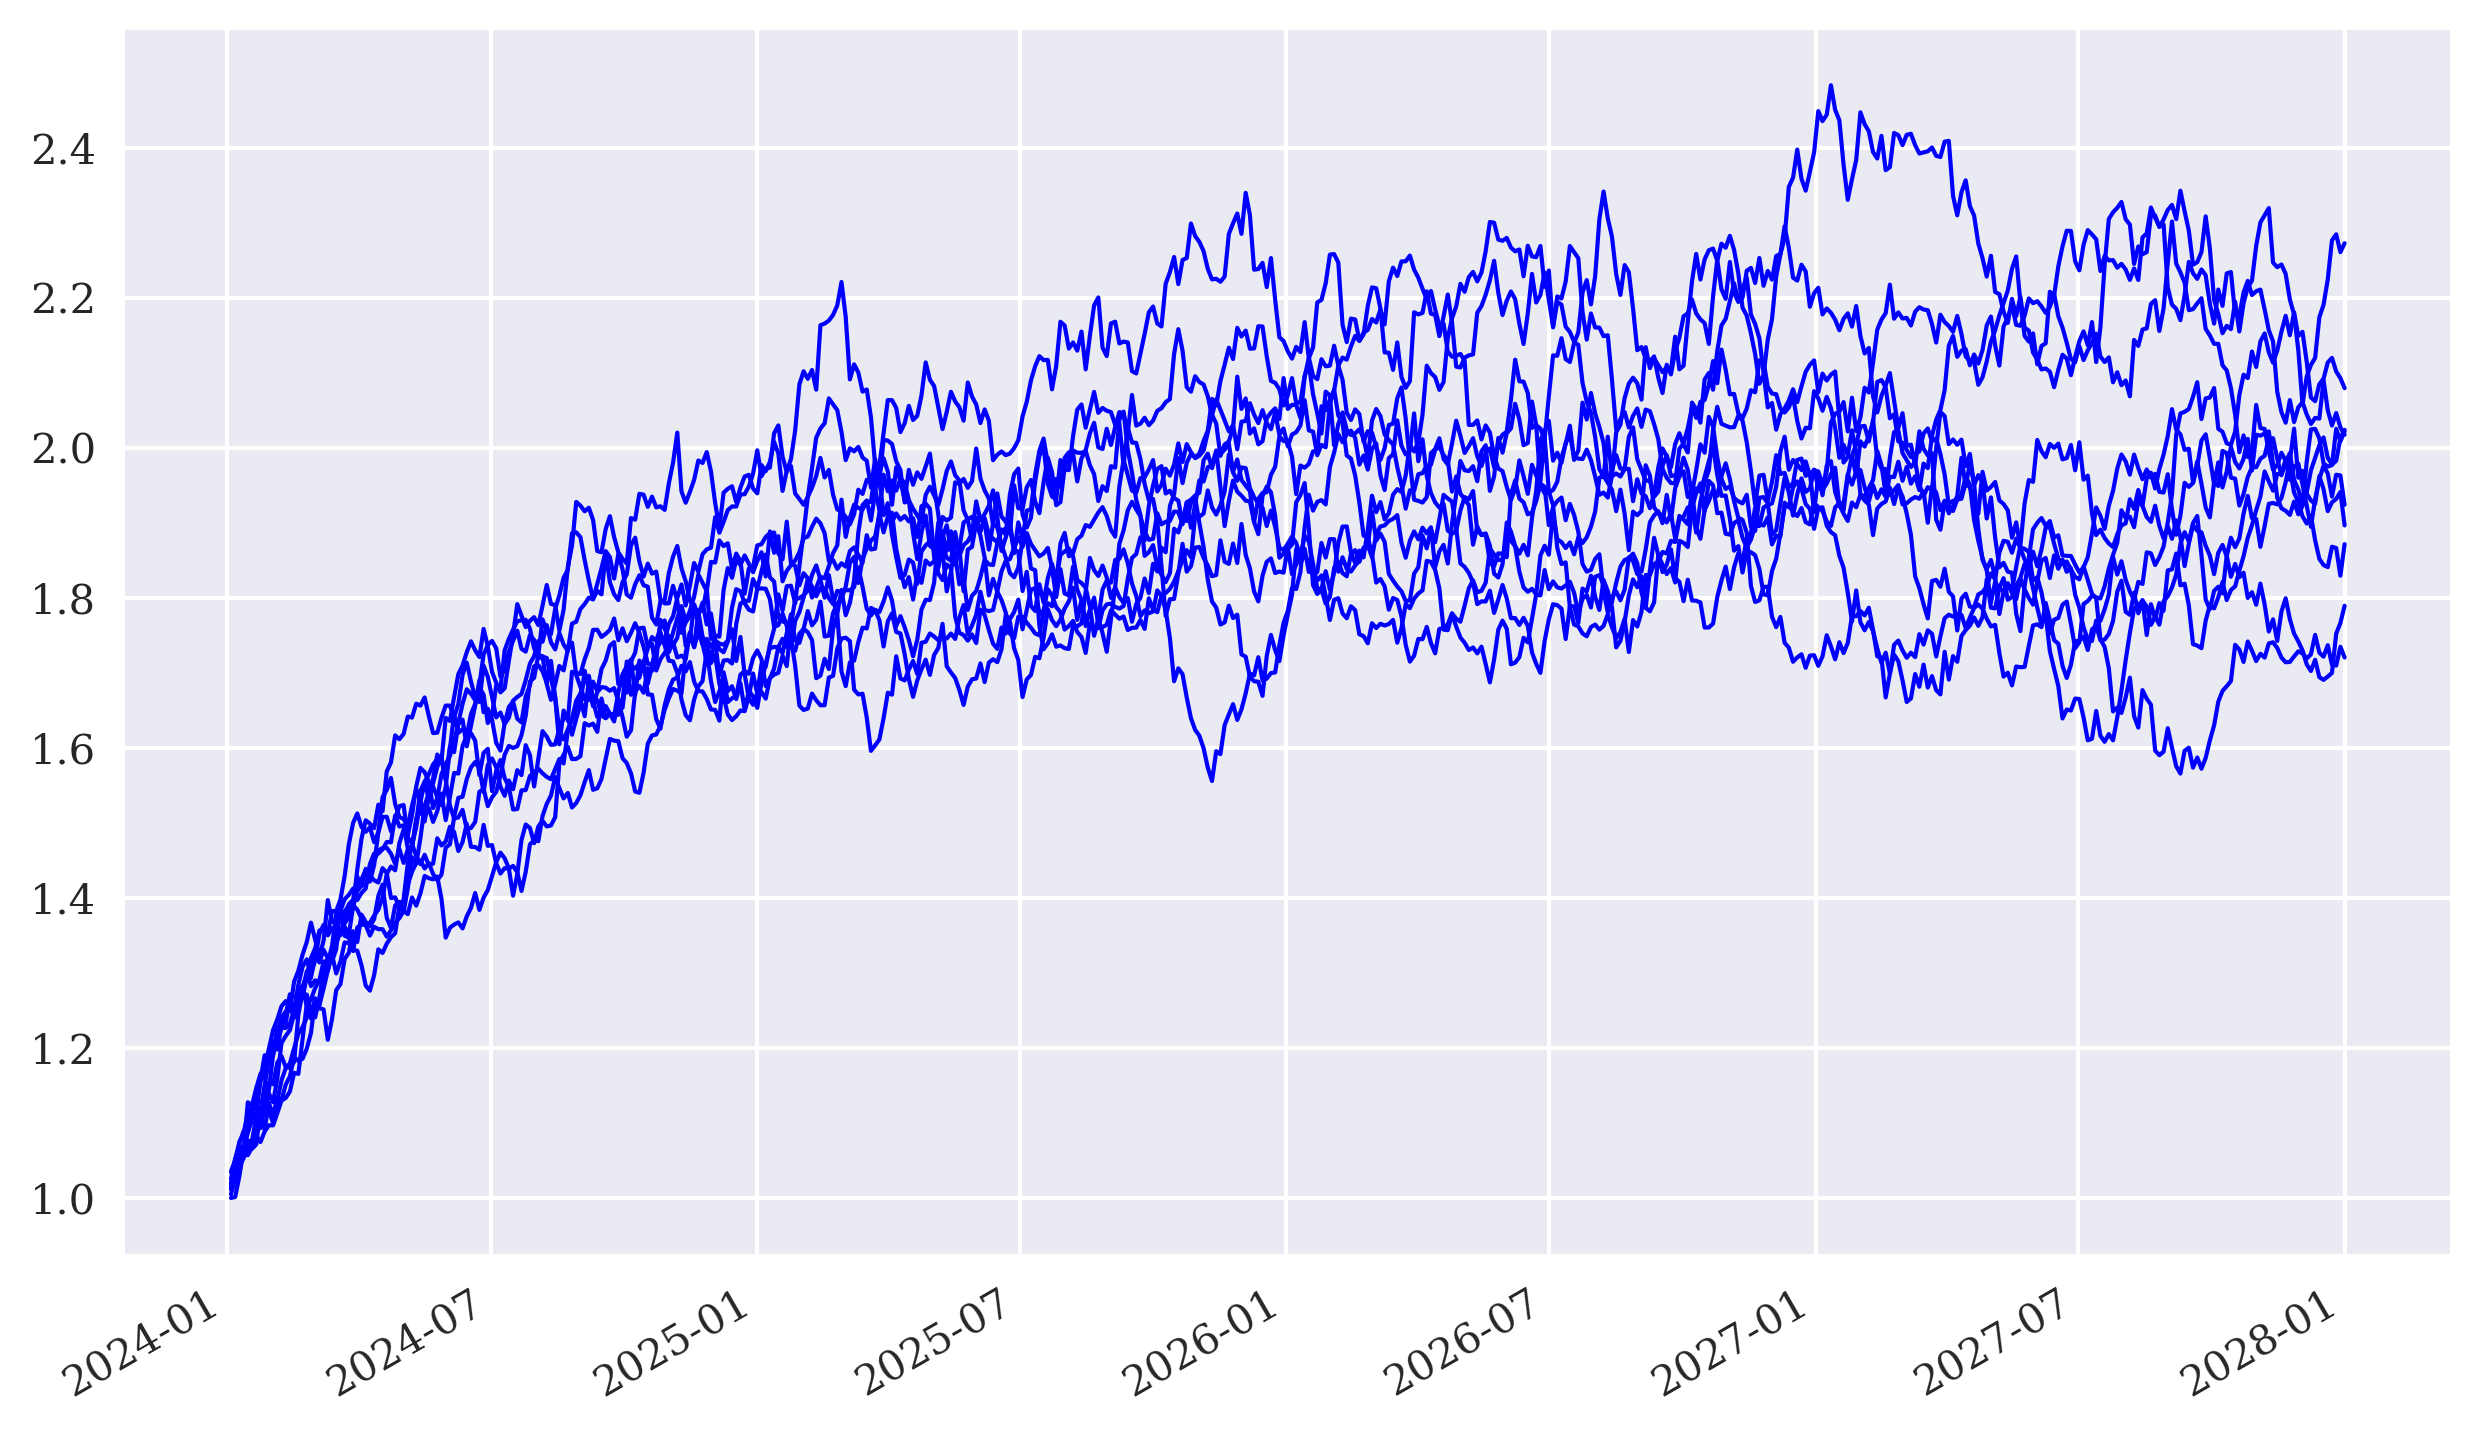

In [33]:
for _ in range(10):
    sim.reset()
    sim.data[sym].plot(figsize=(10, 6), lw=1.0, c='b');

In [34]:
agent = DQLAgent(sim.symbol, sim.feature,
                 sim.n_features, sim, lr=0.0001)

In [35]:
%time agent.learn(500)

episode= 500 | treward= 11.000 | max=286.000
CPU times: total: 3min 44s
Wall time: 3min 18s


In [36]:
agent.test(5)

total reward= 499 | accuracy=0.525
total reward= 499 | accuracy=0.543
total reward= 499 | accuracy=0.527
total reward= 499 | accuracy=0.541
total reward= 499 | accuracy=0.531



In [37]:
sim = Simulation(sym, 'r', 4, start='2024-1-1', end='2028-1-1',
                 periods=2 * 252, min_accuracy=0.6, x0=1,
                 kappa=1.25, theta=1, sigma=0.15,
                 normalize=True, new=True)
sim.seed(100)

In [38]:
agent = DQLAgent(sim.symbol, sim.feature,
                 sim.n_features, sim, lr=0.0001)

In [39]:
%time agent.learn(500)

episode= 500 | treward=  6.000 | max= 84.000
CPU times: total: 1min 52s
Wall time: 2min 1s


In [40]:
agent.test(5)

total reward= 499 | accuracy=0.487
total reward= 499 | accuracy=0.499
total reward= 499 | accuracy=0.477
total reward= 499 | accuracy=0.499
total reward= 499 | accuracy=0.501



<img src="https://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="https://tpq.io" target="_blank">https://tpq.io</a> | <a href="https://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@tpq.io">team@tpq.io</a>